#  <center> Speech Emotion Recognition <center>

Datasets contains 8 types of emotions:

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

# Importing Libraries

In [212]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
Creating a dataframe storing all emotions of the data in dataframe with their paths. I will use this dataframe to extract features for our model training.

In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Mengambil emosi dari nama file
    part = file.split('_')
    if part[2] in ['SAD', 'ANG', 'HAP']:  # Filter untuk emosi 'sad', 'angry', 'happy'
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        
        # Menggabungkan path lengkap dari file
        file_path.append(os.path.join(Crema, file))

# Membuat dataframe untuk emosi file
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Membuat dataframe untuk path file
path_df = pd.DataFrame(file_path, columns=['Path'])

# Menggabungkan dataframe emosi dan path
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Menampilkan lima baris pertama dari dataframe
Crema_df.head()

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
Crema_df.shape

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
#emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
#path_df = pd.DataFrame(file_path, columns=['Path'])
#Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

In [ ]:
Ravdess_df.shape

In [ ]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

In [ ]:
# creating a copy
data_path = Crema_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

## Data Visualisation and Exploration

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [ ]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
path = "/kaggle/input/cremad/AudioWAV/1001_DFA_ANG_XX.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

## Data Augmentation

- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- Using Random transformations and augmenting data before training.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 3. Stretching

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction
With the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it. Extracting MFCC for the current experiment.

> MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [ ]:
def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    #randomly transforming audio data
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

#xx = extract_features(data)
#fns = [noise, stretch, pitch]
#xx1 = extract_features(stretch(data))
#xx.shape, xx1.shape
#xx = get_features(path)
#len(xx)

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [ ]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

In [ ]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

## Load CSV

In [216]:
trainFeatures = pd.read_table("/kaggle/input/mfcc-features/train_features_combined.csv", delimiter =",") 
trainFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-224.968018,88.127022,-28.556711,42.041729,-26.456383,2.425796,-11.314594,6.590621,-17.847683,5.558612,...,-4.974501,-0.567333,-18.406267,0.743784,-14.731791,3.375727,-1.110938,6.291061,1.466656,angry
1,-136.773198,31.956022,-6.451932,9.706217,-8.906907,-9.483890,-1.076323,-2.119147,-8.502661,-0.313184,...,-3.612076,-4.814447,-10.381835,-4.142573,-6.554126,-0.717115,2.655032,2.748287,2.174956,angry
2,-248.623230,81.649124,-30.429928,40.234570,-31.664913,1.797544,-10.668080,5.378362,-18.987909,9.986733,...,-2.077498,-8.139628,-17.467079,-1.917704,-13.126306,7.943971,-0.954535,8.997632,-3.221879,angry
3,-100.947824,12.799493,-4.975743,3.333458,-6.885051,-8.063052,1.238954,-2.811634,-4.860511,-0.631905,...,-3.053434,-5.006016,-7.159232,-4.560851,-3.334749,0.883521,3.125114,2.915285,0.983916,angry
4,-512.800476,67.036659,16.652534,14.732719,1.504934,3.908049,-0.935905,-0.582631,-9.197448,-4.361269,...,-5.011508,-0.741592,-3.763394,-0.052377,-0.403557,-4.546918,-2.480759,-2.854675,-2.769855,angry


In [217]:
testFeatures = pd.read_table("/kaggle/input/mfcc-features/test_features_combined.csv", delimiter =",") 
testFeatures.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-409.781708,138.898575,16.619120,62.106537,-17.951117,20.537199,-10.197814,7.864418,-18.024940,0.866107,...,-5.015299,2.547534,-9.577332,6.215036,-11.494952,5.029482,-9.257662,-0.076080,-3.420002,disgust
1,-233.677643,8.696068,-31.825783,24.878464,-12.394256,9.717953,2.869047,-1.489102,-5.796555,5.779031,...,-2.419949,3.457555,3.048745,-2.770976,2.774320,7.404535,20.457363,4.896526,10.671601,fear
2,-410.981934,151.671387,5.876148,43.884144,-23.448103,24.610785,-14.701571,8.819416,-12.981906,1.977745,...,-1.154785,0.508979,-7.687923,4.037377,-12.825150,3.821622,-6.810735,5.192341,-3.801493,happy
3,-574.189026,69.399467,-16.230627,24.212524,3.046218,-8.011155,-1.873429,-11.898146,-2.485888,-3.896015,...,-7.381905,-3.164908,-1.465565,-2.655161,-5.886915,-5.339420,0.675956,-3.710739,0.588331,happy
4,-356.280884,68.444229,0.273231,-4.796208,-29.325169,7.266706,-1.323918,-15.098816,-5.528758,-3.504280,...,7.690853,-16.099146,6.859893,-0.259191,-7.920983,-2.280723,-2.810234,-8.536092,-2.973209,angry


In [218]:
train = trainFeatures[trainFeatures['labels'].isin(["angry", "happy", "sad"])]
train.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-224.968018,88.127022,-28.556711,42.041729,-26.456383,2.425796,-11.314594,6.590621,-17.847683,5.558612,...,-4.974501,-0.567333,-18.406267,0.743784,-14.731791,3.375727,-1.110938,6.291061,1.466656,angry
1,-136.773198,31.956022,-6.451932,9.706217,-8.906907,-9.483890,-1.076323,-2.119147,-8.502661,-0.313184,...,-3.612076,-4.814447,-10.381835,-4.142573,-6.554126,-0.717115,2.655032,2.748287,2.174956,angry
2,-248.623230,81.649124,-30.429928,40.234570,-31.664913,1.797544,-10.668080,5.378362,-18.987909,9.986733,...,-2.077498,-8.139628,-17.467079,-1.917704,-13.126306,7.943971,-0.954535,8.997632,-3.221879,angry
3,-100.947824,12.799493,-4.975743,3.333458,-6.885051,-8.063052,1.238954,-2.811634,-4.860511,-0.631905,...,-3.053434,-5.006016,-7.159232,-4.560851,-3.334749,0.883521,3.125114,2.915285,0.983916,angry
4,-512.800476,67.036659,16.652534,14.732719,1.504934,3.908049,-0.935905,-0.582631,-9.197448,-4.361269,...,-5.011508,-0.741592,-3.763394,-0.052377,-0.403557,-4.546918,-2.480759,-2.854675,-2.769855,angry


In [219]:
test = testFeatures[testFeatures['labels'].isin(["angry", "happy", "sad"])]
test.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
2,-410.981934,151.671387,5.876148,43.884144,-23.448103,24.610785,-14.701571,8.819416,-12.981906,1.977745,...,-1.154785,0.508979,-7.687923,4.037377,-12.825150,3.821622,-6.810735,5.192341,-3.801493,happy
3,-574.189026,69.399467,-16.230627,24.212524,3.046218,-8.011155,-1.873429,-11.898146,-2.485888,-3.896015,...,-7.381905,-3.164908,-1.465565,-2.655161,-5.886915,-5.339420,0.675956,-3.710739,0.588331,happy
4,-356.280884,68.444229,0.273231,-4.796208,-29.325169,7.266706,-1.323918,-15.098816,-5.528758,-3.504280,...,7.690853,-16.099146,6.859893,-0.259191,-7.920983,-2.280723,-2.810234,-8.536092,-2.973209,angry
5,-344.991364,56.161900,-21.221060,6.660259,-22.434557,9.121241,-3.040804,-17.465864,-3.080345,-4.023541,...,9.122016,-13.268463,9.707204,-0.865990,-7.356742,-0.598327,-1.055634,-4.640522,1.432572,angry
6,-378.017456,117.926369,27.451477,20.898643,-10.328207,17.941603,4.995150,-12.723850,5.309674,-3.542826,...,-4.011790,-11.872843,6.765612,-6.979980,-0.724146,-2.890197,-4.367773,-3.368738,-10.506060,sad


## Data Preparation

In [220]:
x_train = train.iloc[: ,:-1].values
y_train = train['labels'].values
x_test = test.iloc[: ,:-1].values
y_test = test['labels'].values

In [221]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

In [222]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16152, 20), (16152, 3), (1731, 20), (1731, 3))

In [223]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_train = np.expand_dims(x_train, axis=2)

x_test = np.expand_dims(x_test, axis=2)
x_test = np.expand_dims(x_test, axis=2)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16152, 20, 1, 1), (16152, 3), (1731, 20, 1, 1), (1731, 3))

## Modelling

In [229]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential()

# TimeDistributed Conv1D layers with L2 regularization
model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01)), input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

model.add(TimeDistributed(Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

model.add(TimeDistributed(Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

model.add(TimeDistributed(Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))

# Add TimeDistributed Flatten layer
model.add(TimeDistributed(Flatten()))

# LSTM layers
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Fully connected layers with L2 regularization
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Print the model summary
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_318 (TimeDi (None, 20, 1, 16)         64        
_________________________________________________________________
time_distributed_319 (TimeDi (None, 20, 1, 16)         64        
_________________________________________________________________
time_distributed_320 (TimeDi (None, 20, 1, 16)         0         
_________________________________________________________________
time_distributed_321 (TimeDi (None, 20, 1, 32)         1568      
_________________________________________________________________
time_distributed_322 (TimeDi (None, 20, 1, 32)         128       
_________________________________________________________________
time_distributed_323 (TimeDi (None, 20, 1, 32)         0         
_________________________________________________________________
time_distributed_324 (TimeDi (None, 20, 1, 64)       

In [ ]:
import matplotlib.pyplot as plt

# Get model summary
summary_list = []
model.summary(print_fn=lambda x: summary_list.append(x))
summary_string = "\n".join(summary_list)

# Create a figure and plot the text as is
plt.figure(figsize=(10, len(summary_list)/2))
plt.text(0.01, 0.5, summary_string, {'fontsize': 10}, fontproperties='monospace')
plt.axis('off')

# Save the plot as an image file
plt.savefig('model_summar12y.png', bbox_inches='tight')

# Show the plot (optional)D
plt.show()


In [ ]:
from keras.optimizers import adam_v2
from keras.callbacks import ReduceLROnPlateau

# Set optimizer dengan parameter yang disesuaikan
optimizer = adam_v2.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile model dengan optimizer dan loss function
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback untuk mengurangi learning rate jika tidak ada peningkatan pada val_loss
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-7)

# Set jumlah epochs dan batch size
epochs = 25
batch_size = 32

# Train model dengan callback
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])


55/55 [==============================] - 0s 5ms/step - loss: 0.6281 - accuracy: 0.7504
Accuracy of our model on test data : 75.04%
Final Training Loss: 0.5498794913291931
Final Testing Loss: 0.6739025712013245
Final Training Accuracy: 0.8010153770446777
Final Testing Accuracy: 0.7336799502372742
Gambar loss disimpan dengan nama Image_loss_batch32_epoch23_trainloss0.55_testloss0.67.png
Gambar accuracy disimpan dengan nama Image_accuracy_batch32_epoch23_trainacc0.80_testacc0.73.png


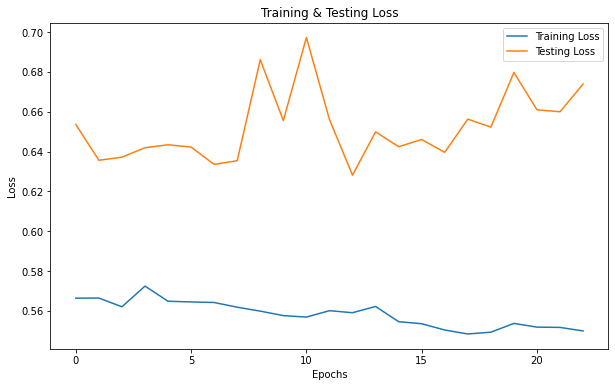

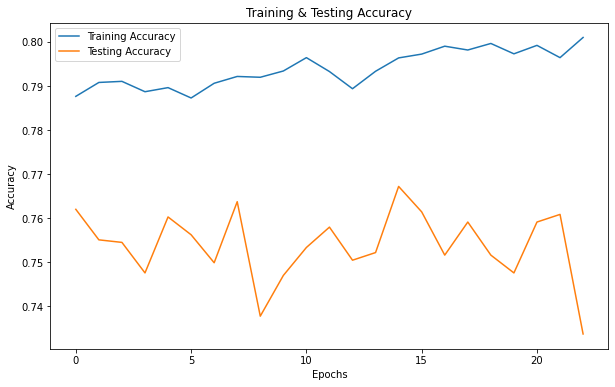

In [239]:
import matplotlib.pyplot as plt

# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Accuracy of our model on test data : {:.2f}%".format(test_accuracy * 100))

# Mencetak nilai terakhir dari training loss, testing loss, training accuracy, dan testing accuracy
train_loss = history.history['loss'][-1]
test_loss = history.history['val_loss'][-1]
train_acc = history.history['accuracy'][-1]
test_acc = history.history['val_accuracy'][-1]

print(f"Final Training Loss: {train_loss}")
print(f"Final Testing Loss: {test_loss}")
print(f"Final Training Accuracy: {train_acc}")
print(f"Final Testing Accuracy: {test_acc}")

# Plotting training and testing loss and accuracy
epochs = range(len(history.history['accuracy']))  # Adjusting the range to match the actual number of epochs

# Plotting training and testing loss
fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
train_loss_history = history.history['loss']
test_loss_history = history.history['val_loss']
ax_loss.plot(epochs, train_loss_history, label='Training Loss')
ax_loss.plot(epochs, test_loss_history, label='Testing Loss')
ax_loss.set_title('Training & Testing Loss')
ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("Loss")
ax_loss.legend()

# Menyimpan gambar loss
# batch_size = 128  # Gantilah dengan ukuran batch yang Anda gunakan dalam pelatihan
epoch_count = len(epochs)
loss_filename = f"Image_loss_batch{batch_size}_epoch{epoch_count}_trainloss{train_loss:.2f}_testloss{test_loss:.2f}.png"
fig_loss.savefig(loss_filename)
print(f"Gambar loss disimpan dengan nama {loss_filename}")

# Plotting training and testing accuracy
fig_acc, ax_acc = plt.subplots(figsize=(10, 6))
train_acc_history = history.history['accuracy']
test_acc_history = history.history['val_accuracy']
ax_acc.plot(epochs, train_acc_history, label='Training Accuracy')
ax_acc.plot(epochs, test_acc_history, label='Testing Accuracy')
ax_acc.set_title('Training & Testing Accuracy')
ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Accuracy")
ax_acc.legend()

# Menyimpan gambar accuracy
acc_filename = f"Image_accuracy_batch{batch_size}_epoch{epoch_count}_trainacc{train_acc:.2f}_testacc{test_acc:.2f}.png"
fig_acc.savefig(acc_filename)
print(f"Gambar accuracy disimpan dengan nama {acc_filename}")

plt.show()


In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)

# Simpan confusion matrix sebagai gambar
plt.savefig('confusion_matrix.png')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

- Obtained is an acceptalbe model but poorly regularised. There is a clear case of overfitting here.
- Model is more accurate in predicting surprise, angry and calm emotions as audio corresponding to these emotions are much different to other emotions in a lot of ways like pitch, speed etc..
- Ooverall 65% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.
- Perhaps, better augmentation, realtime/on the go data augmentation could have produced a more regularised result.
- Different architectures and normalization methods can also be explored. 